In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

### Get shape file of the suburbs

In [2]:
city='melbourne'
central_suburbs = gpd.read_file(f"../../../data/SpatialData/MelbourneSuburbs.shp")
central_suburbs = central_suburbs[['SAL_NAME21', 'geometry']]

### Get gentrification index categories, and join with spatial boundaries

In [3]:
classifications = pd.read_csv(f"../../../data/GentrificationIndex/MelbourneIndex/FromGuardian.csv")
classifications = classifications.merge(central_suburbs, on='SAL_NAME21', how='left')

### Keep only those with boundaries

In [4]:
filtered_df = classifications[classifications['geometry'].notnull()].copy()

mapping_idx = {1: 'Susceptible to displacement', 2: "Low-income households being displaced",
           4: "Early gentrification", 5: "Mixed income", 6:"Risk of exclusivity", 7: "Becoming exclusive",
           8 : "Exclusive"}

filtered_df['classification_new'] = filtered_df['Classification'].map(mapping_idx)

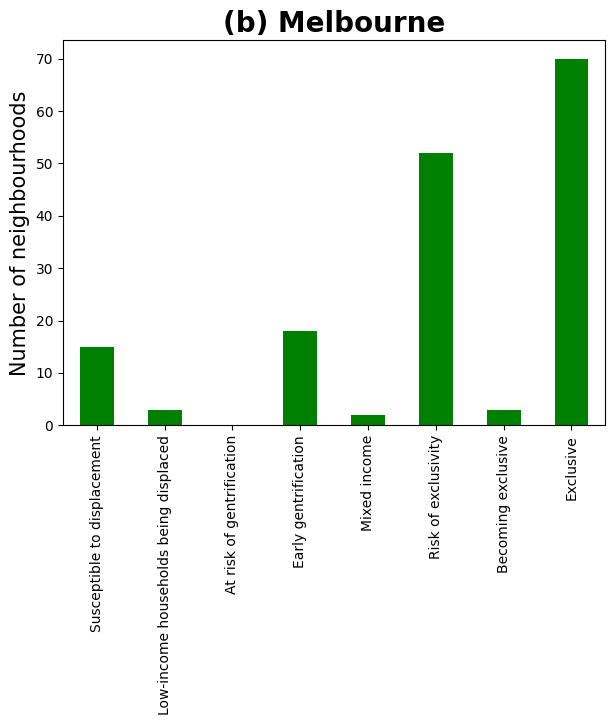

In [5]:
order = ["Susceptible to displacement", "Low-income households being displaced", "At risk of gentrification",
    "Early gentrification","Mixed income","Risk of exclusivity", "Becoming exclusive", "Exclusive"]

# Make sure classification_new is treated as categorical in the right order
filtered_df["classification_new"] = pd.Categorical(
    filtered_df["classification_new"], categories=order, ordered=True)

# Count with all categories (missing ones get 0)
counts = filtered_df["classification_new"].value_counts().reindex(order, fill_value=0)

# Plot in desired order
fig, ax = plt.subplots(figsize=(7,5))
counts.plot(ax=ax, kind="bar", color="green")
ax.set_xlabel("")
ax.set_ylabel("Number of neighbourhoods", fontsize=15)
ax.set_title('(b) Melbourne', fontsize=20, fontweight = 'bold');
fig.savefig("../Figures/Melbourne_Barplot_GI.png", bbox_inches='tight', pad_inches=0.2)   

### Check plotting

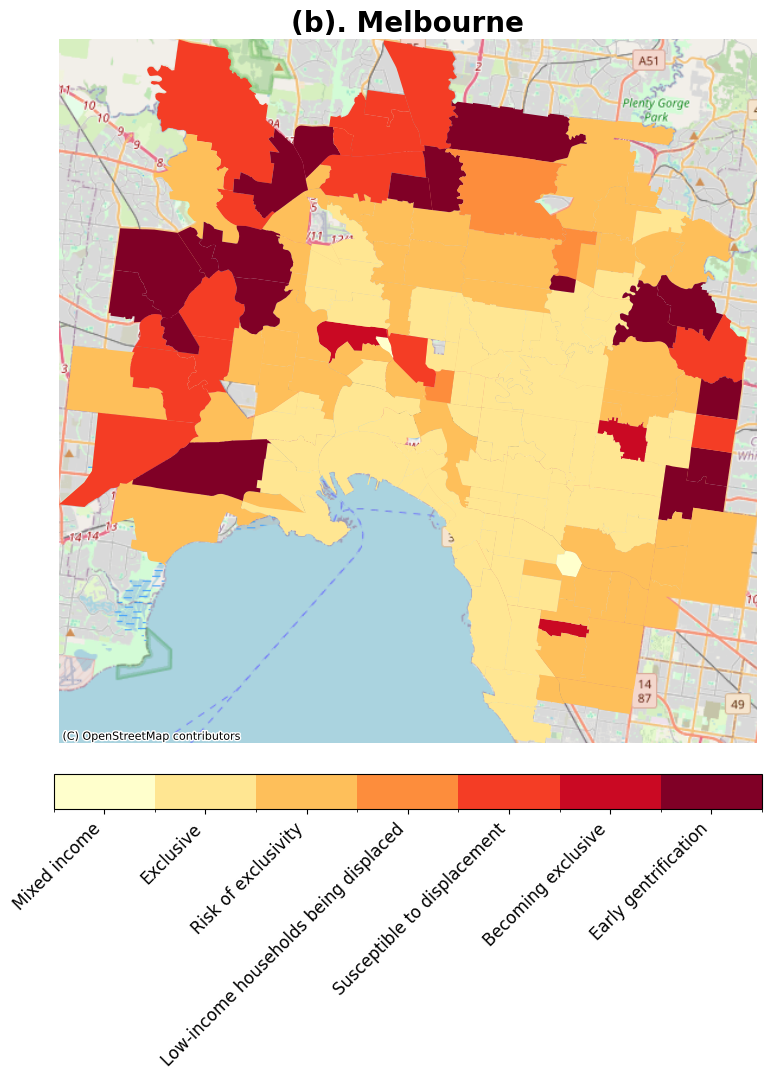

In [28]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# --- Prepare GeoDataFrame ---
gdf = gpd.GeoDataFrame(filtered_df, geometry=filtered_df['geometry'])
gdf.set_crs(epsg=4326, inplace=True)

# Reproject to Web Mercator
gdf_proj = gdf.to_crs(epsg=3857)

# --- Define discrete colormap ---
categories = gdf_proj['classification_new'].unique()
# categories.sort()  # optional, to order labels
n_categories = len(categories)

# Choose a colormap and create discrete colors
cmap = plt.get_cmap('YlOrRd', n_categories)  # or 'Set3', 'Paired', etc.
colors = cmap(np.arange(n_categories))
custom_cmap = mcolors.ListedColormap(colors)

# Map each category to a numeric code
category_to_code = {cat: i for i, cat in enumerate(categories)}
gdf_proj['cat_code'] = gdf_proj['classification_new'].map(category_to_code)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 10))
gdf_proj.plot(column='cat_code', cmap=custom_cmap, ax=ax, legend=False)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Trim to GeoDataFrame extent
xmin, ymin, xmax, ymax = gdf_proj.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis('off')
ax.set_title("(b). Melbourne", fontsize=20, fontweight='bold')

# --- Add discrete horizontal colorbar ---
norm = mcolors.BoundaryNorm(np.arange(-0.5, n_categories + 0.5, 1), ncolors=n_categories)
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm._A = []

cb = fig.colorbar(
    sm,
    ax=ax,
    orientation='horizontal',
    fraction=0.046,
    pad=0.04,
    ticks=np.arange(n_categories)
)

# cb0.ax.set_xticklabels(list(mapping.keys()), rotation=45, ha='right')
# cb0.ax.tick_params(labelsize=14)

cb.set_ticklabels(categories, rotation=45, ha='right')  # set category labels
cb.ax.tick_params(labelsize=12)
# cb.set_label("Classification", fontsize=14)

plt.show()
fig.savefig("../Figures/Melbourne_GI.png", bbox_inches='tight', pad_inches=0.2)

Not on guardian map: Kingsbury, Essendon Fields, Tottenham, Seaholme, South Wharf, Princes Hill

In [72]:
gdf = gpd.GeoDataFrame(filtered_df, geometry=filtered_df['geometry'], crs= central_suburbs.crs)
center = gdf.geometry.union_all().centroid

m = folium.Map(location=[center.y, center.x], zoom_start=11)

folium.Choropleth(
    geo_data=gdf,
    name="Choropleth",
    data=gdf,
    columns=["SAL_NAME21", "Classification"],  # Replace with your column
    key_on="feature.properties.SAL_NAME21",
    fill_color="YlOrRd",
    fill_opacity=0.9,
    line_opacity=0.2,
    legend_name="Metric Value",
).add_to(m)

# # Add hover tooltips
# folium.GeoJson(
#     central_suburbs,
#     tooltip=folium.GeoJsonTooltip(fields=["SAL_NAME21"], aliases=["Suburb:"]),
#     name="Suburb Labels"
# ).add_to(m)

m


## Remap to 4 categories

In [79]:
mapping = {1: 0,2: 0,3: 1, 4: 1,5: 2,6: 2,7: 3, 8: 3}

filtered_df['classification_new'] = filtered_df['Classification'].map(mapping)
filtered_df.to_csv(f"../../../data/GentrificationIndex/MelbourneIndex/Edited.csv", index=False)

/tmp/ipykernel_21883/3748666840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['classification_new'] = filtered_df['Classification'].map(mapping)
